## Lesson 17:
### Exercise 1: Supernova distances and redshifts (part 1)
---

In [2]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from astroML.datasets import generate_mu_z
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
import sklearn.metrics
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from tqdm.notebook import tqdm

import seaborn as sns
%config InlineBackend.figure_format='retina'

#----------------------------------------------------------

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=False)

#----------------------------------------------------------
c = sns.color_palette('rocket', 7)
plt.rcParams['figure.figsize'] = (7, 4)

/home/nicolofiaba/.local/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


First we can visualize our dataset: 
- On the x-axis we have measurements of the redshift $z$ for $N$ Supernovae events
- On the y-axis we have the values of the magnitude defined as:
$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$
- The dataset also contains the errors on $\mu$

To keep it clean, let's select 100 datapoints among the whole dataset.

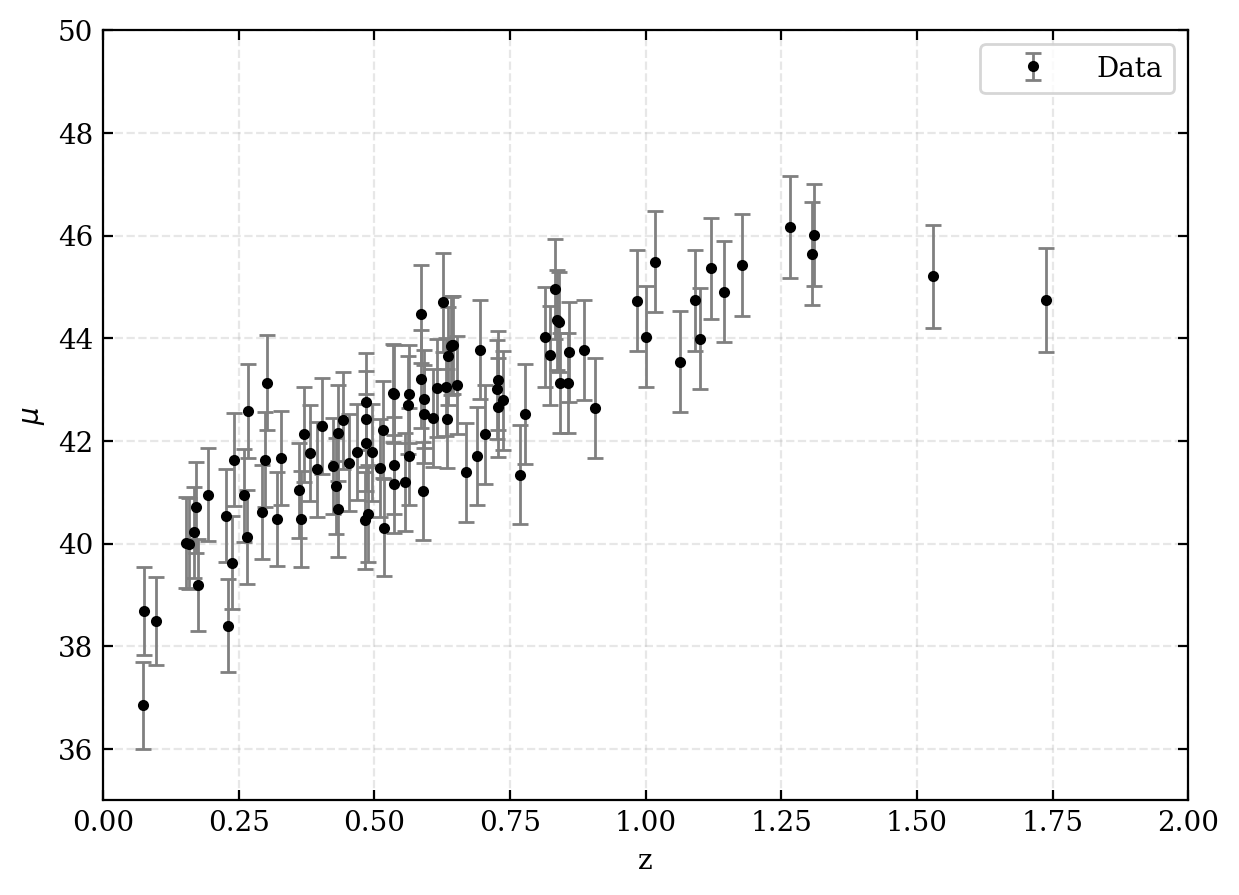

In [3]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

fig = plt.figure(figsize=(7,5))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='best')
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid(True, ls='--', alpha=0.3)

### Linear regression:

In [4]:
lin_reg = LinearRegression()
lin_reg.fit(z_sample[:, None], mu_sample[:, None], sample_weight=dmu)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)

[39.60456481] [[4.5911933]]


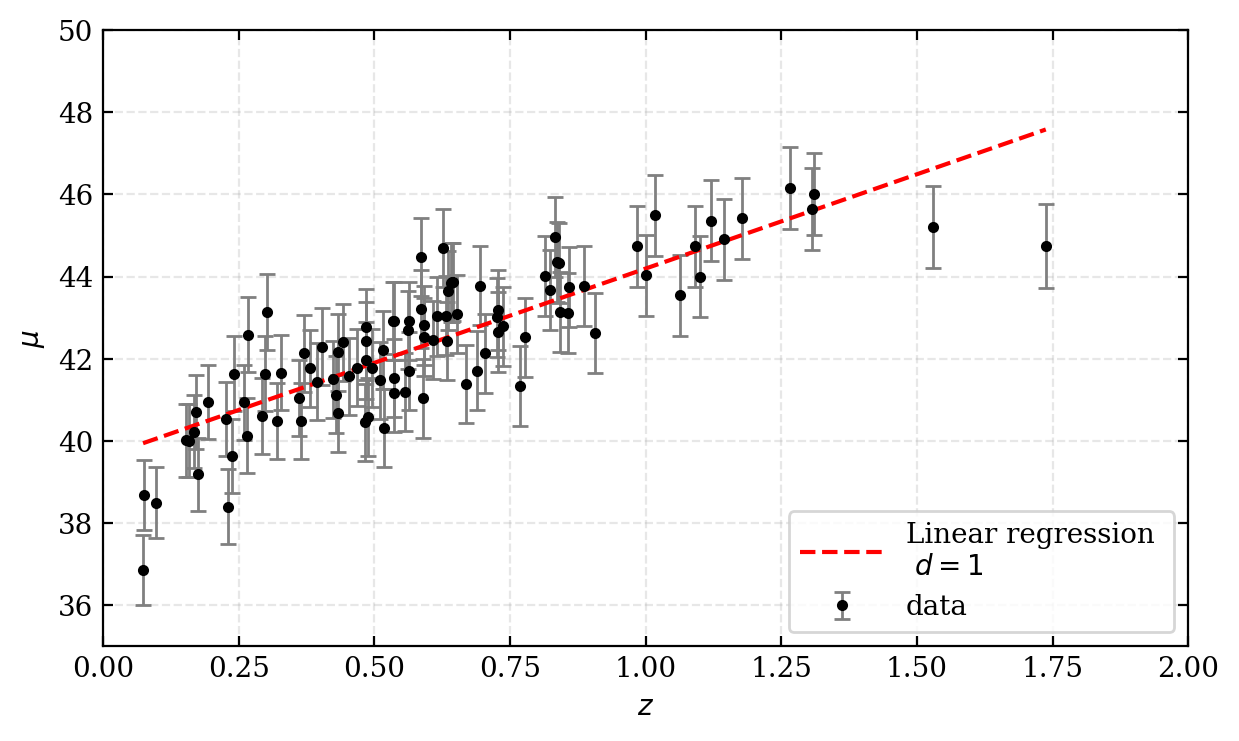

In [5]:
X_line = [[np.min(z_sample)], [np.max(z_sample)]]
y_pred = lin_reg.predict(X_line)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(X_line, y_pred, c='r', ls='--', label='Linear regression \n $d=1$')
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid(True, ls='--', alpha=0.3)

### Polynomial regression:

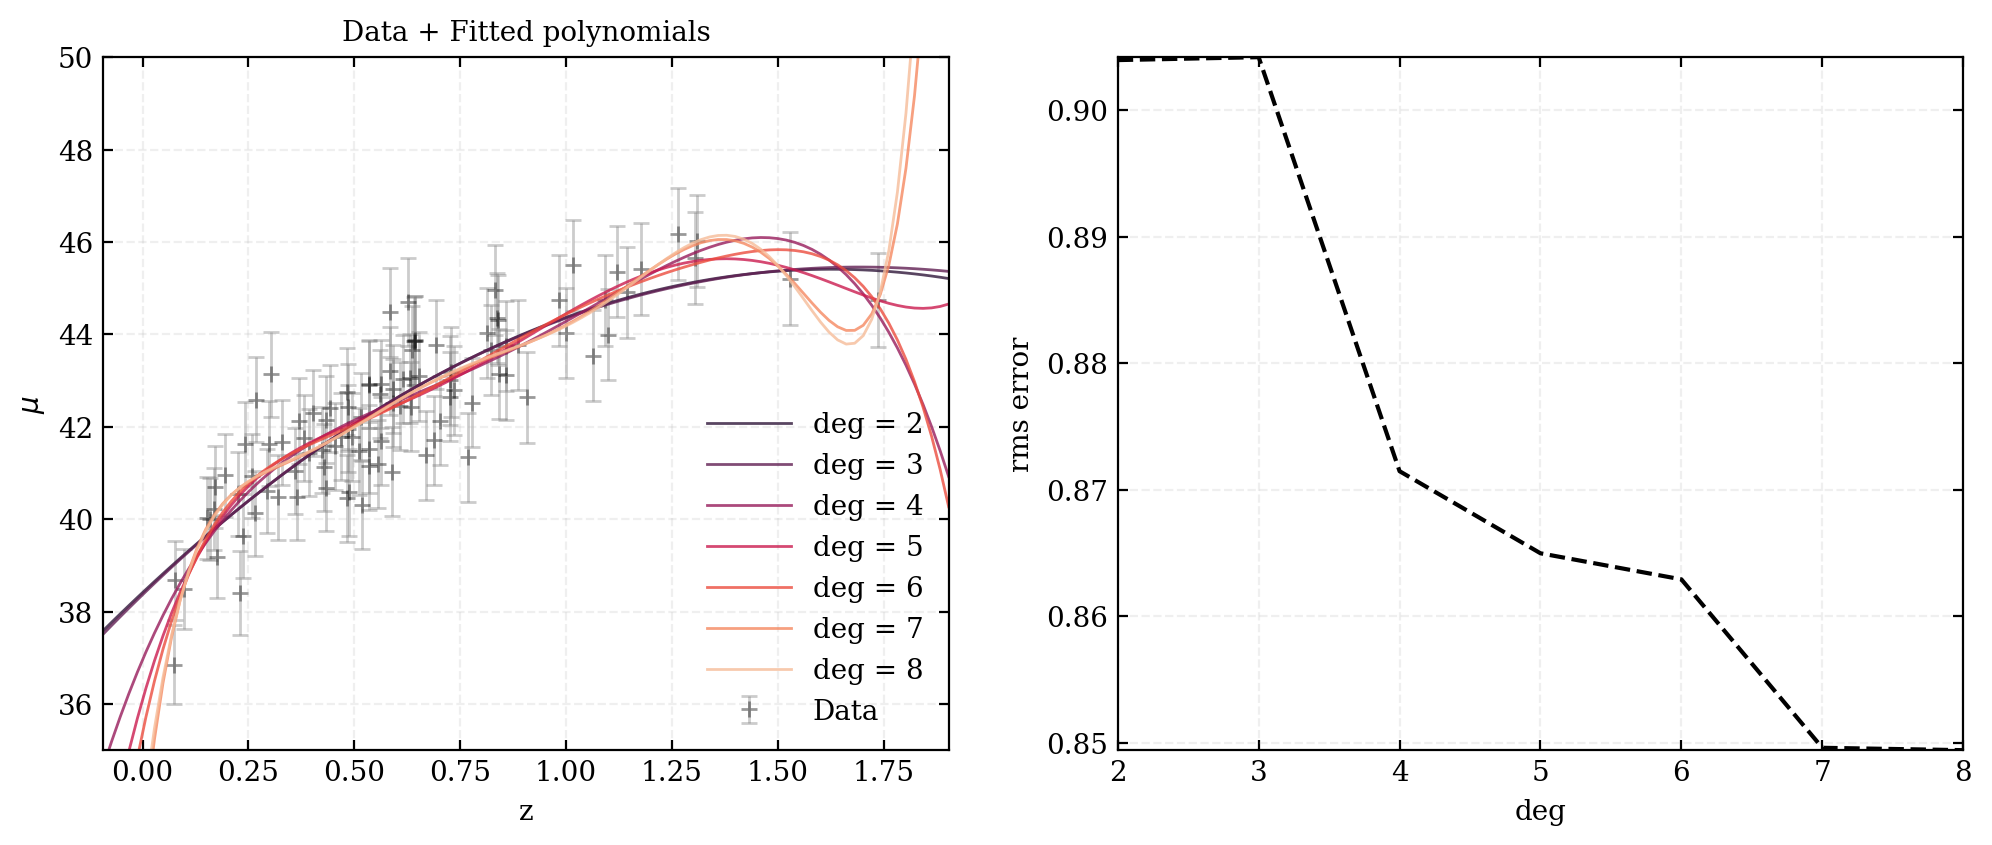

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,4.5))
ax, ax1 = axes
ax.errorbar(z_sample, mu_sample, dmu, fmt='+k', ecolor='gray', lw=1,label='Data', alpha=0.4, zorder=0)

xlim_sx = z_sample.min() - (z_sample.max()-z_sample.min())* 0.1
xlim_dx = z_sample.max() + (z_sample.max()-z_sample.min())* 0.1

deg = np.arange(2, 9)
model_err = np.zeros(len(deg))

for i in range(len(deg)):
    
    model = PolynomialRegression(deg[i])
    model.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    y_model = model.predict(np.linspace(xlim_sx, xlim_dx, 100)[:, np.newaxis])
    ax.plot(np.linspace(xlim_sx, xlim_dx, 100), y_model, ls='-', 
            label=f'deg = {deg[i]}', lw=1., color=c[i], alpha=0.8)
    model_err[i] = np.sqrt(1/len(z_sample) * np.sum((mu_sample - model.predict(z_sample[:, np.newaxis]))**2))
       
ax.set_xlabel("z")
ax.set_ylabel("$\mu$")
ax.legend(loc='best', frameon=False)
ax.set_ylim(35,50)
ax.set_title('Data + Fitted polynomials')

ax1.plot(deg, model_err, ls='--', c='k')
# ax1.set_ylim(0.83, 0.92)
ax1.set_xlabel('deg')
ax1.set_ylabel('rms error')

for _ in axes:
    _.grid(True, ls='--', alpha=0.2)

Just by looking at the fit functions in the left side plot shown above, it seems quite clear that the highest order polynomials ($deg = 7, 8$) are **overfitting** the data, capturing the spurious variance due to statistical error but not characterizing the underlying relation.

##### Comments: 

1. The *rms error* on the model has the following expression:
    $$\epsilon = \sqrt{\frac{1}{N}\sum_{i=1}^{N}\left[y_i - \sum_{m=0}^d \theta_0^{(n)}x_i^m\right]^2}$$
    with $N$ being the number of samples.
2. The *rms error* is decreasing for increasing polynomial degree. That makes perfect sense, but, in order to pick the best model, we want to test the fit on a validation subset of the whole dataset (On which the model is not trained). The lowest value of that error is pointing towards the best model.
> **Key point**: A model is good if it manages to accurately predict the position of new points.

In order to achieve 2. let's implement a **Cross Validation** approach.

### K-Fold Cross Validation

In [7]:
# rms error as defined above
def my_loss_func(y_true, y_pred):
    diff = np.sum((y_true - y_pred)**2) 
    return np.sqrt(diff/len(y_true))

We define a **"KFold"** object so that we can shuffle the dataset before splitting it into 10 cross validation subsets.

Best fit: 5 ° order polynomial function


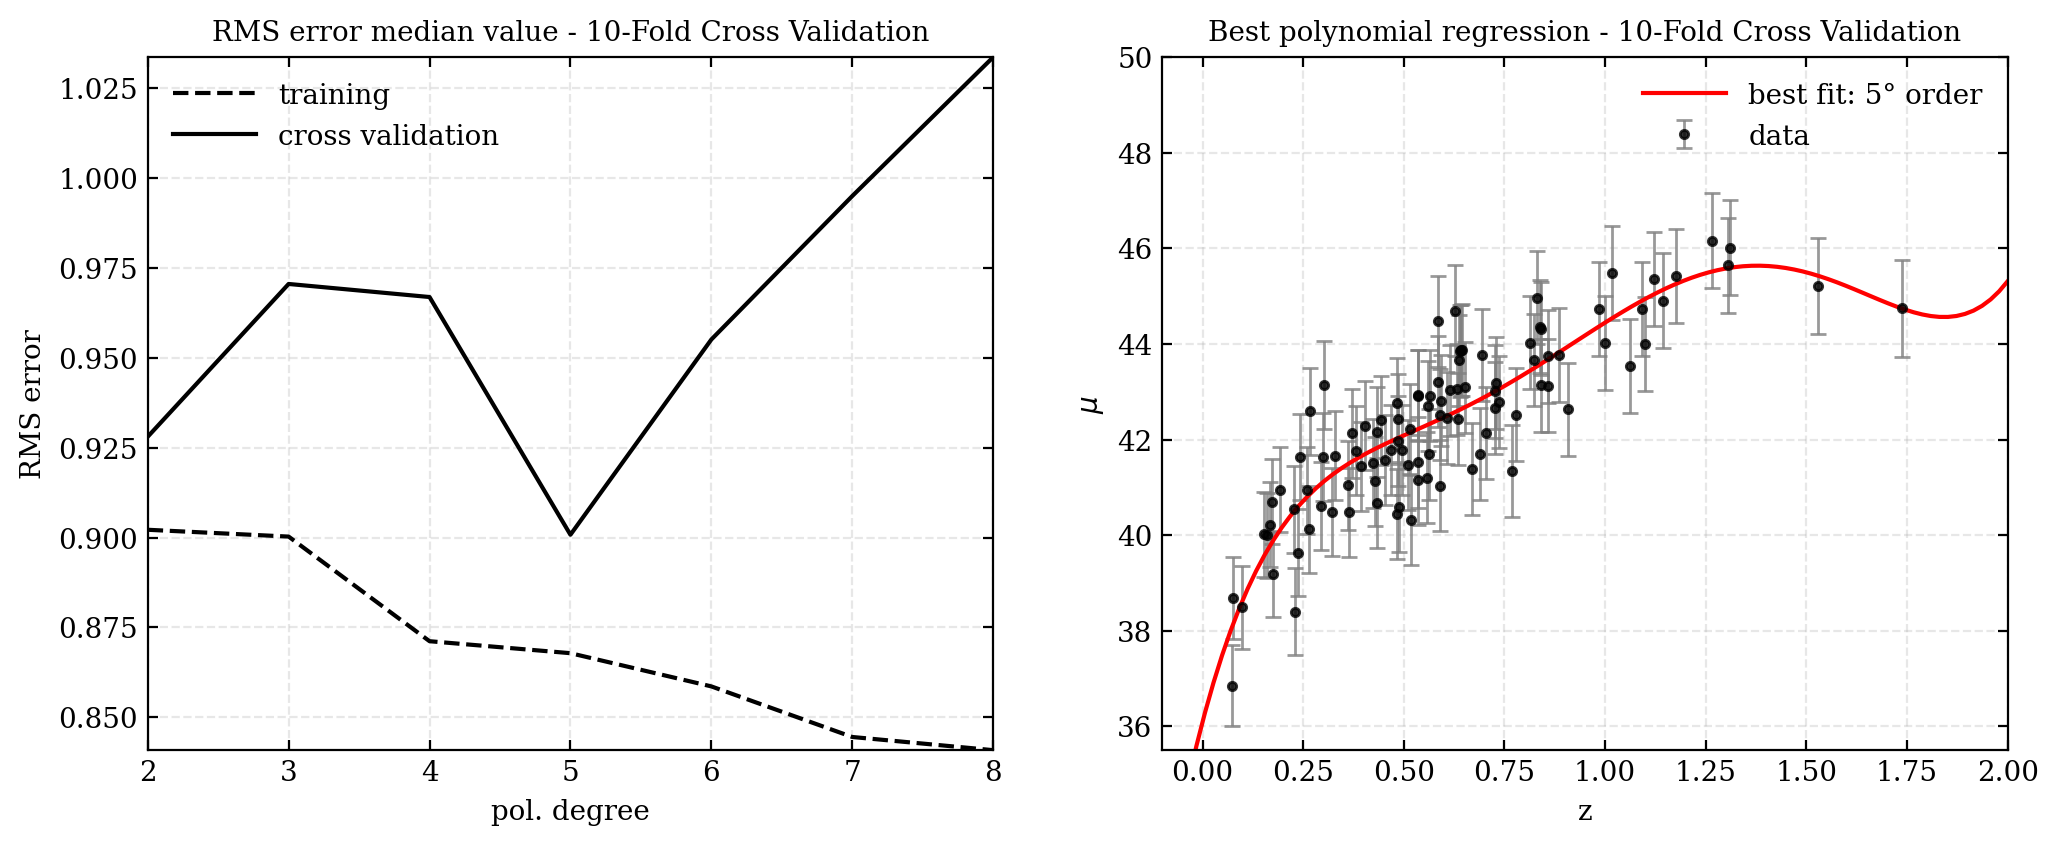

In [34]:
kfold = KFold(n_splits=10, shuffle=True, random_state=None)

# Define the "score" function that we will assign to each prediction
my_scorer = make_scorer(my_loss_func)

test_scores = np.zeros(len(deg))
train_scores = np.zeros(len(deg))

for i in range(len(deg)):
    model = PolynomialRegression(deg[i])
    cv_result = cross_validate(model, z_sample[:, np.newaxis], mu_sample, cv=kfold, 
                           scoring=my_scorer, 
                           return_train_score=True)
    test_scores[i] = np.median(cv_result['test_score']) 
    train_scores[i] = np.median(cv_result['train_score'])
    
fig, ax = plt.subplots(1, 2, figsize=(12,4.5))

plt.subplot(121)

plt.plot(deg, train_scores, ls='--', c='k', label='training')
plt.xlabel('pol. degree')
plt.ylabel('RMS error')

plt.plot(deg, test_scores, ls='-', c='k', label='cross validation')

plt.title('RMS error median value - 10-Fold Cross Validation')
plt.legend(loc='best', frameon=False);

# Let's plot the best model according to cross validation
print('Best fit:',deg[np.where(test_scores == test_scores.min())][0],'° order polynomial function')

model_ = PolynomialRegression(deg[np.where(test_scores == test_scores.min())][0])
model_.fit(z_sample[:, None], mu_sample, dmu)
xgrid = np.linspace(-0.1, 2, 100)
ypred = model_.predict(xgrid[:, None])

plt.subplot(122)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data', alpha=0.8)
plt.plot(xgrid, ypred, c='r', label=f'best fit: {deg[np.where(test_scores == test_scores.min())][0]}° order')
plt.xlim(-0.1, 2)
plt.ylim(35.5, 50)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Best polynomial regression - 10-Fold Cross Validation')
plt.legend(loc='best', frameon=False);

for _ in ax:
    _.grid(True, ls='--', alpha=0.3)

- Now let's repeat this many times in a loop so that we can pick the best value for the polynomial degree.

  0%|          | 0/500 [00:00<?, ?it/s]

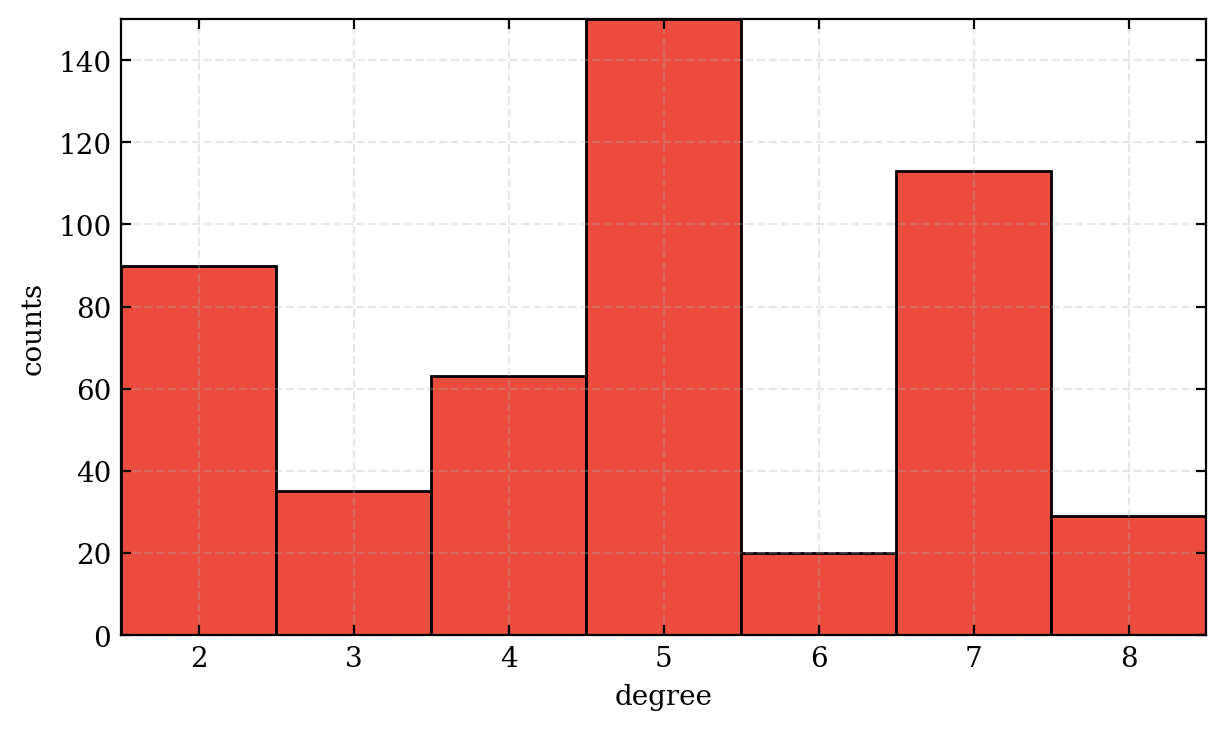

In [41]:
N = 500

best_degree = np.zeros(N)

for n in tqdm(range(N)):
    test_scores = np.zeros(len(deg))
    train_scores = np.zeros(len(deg))
    for i in range(len(deg)):
        model = PolynomialRegression(deg[i])
        cv_result = cross_validate(model, z_sample[:, np.newaxis], mu_sample, cv=kfold, 
                               scoring=my_scorer, 
                               return_train_score=True)
        test_scores[i] = np.median(cv_result['test_score']) 
        train_scores[i] = np.median(cv_result['train_score'])
    best_degree[n] = deg[np.argmin(test_scores)]

bins = np.arange(min(best_degree) - 0.5, max(best_degree) + 1.5, 1)
plt.hist(best_degree, bins=bins, color=c[4])
plt.ylabel('counts')
plt.xlabel('degree')
plt.grid(True, ls='--', alpha=0.3)

In [33]:
values, counts = np.unique(best_degree, return_counts=True)
count_max_ind = np.argmax(counts)
best_n = values[count_max_ind]
print("%i times out of %i, %i was identified as the best polynomial degree." % (counts[count_max_ind], N, best_n))

142 times out of 500, 5 was identified as the best polynomial degree.


### Learning curves (Polynomial regression)

For this polynomial degree, let's vary the number of data points used in the training set and build the **learning curve**. 

We first split our 100 points dataset in a validation set and a training set. We will then select an increasing number of training points on which to perform the polynomial fit and we compute the training error.

In [11]:
ratio = 0.3

/home/nicolofiaba/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/nicolofiaba/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


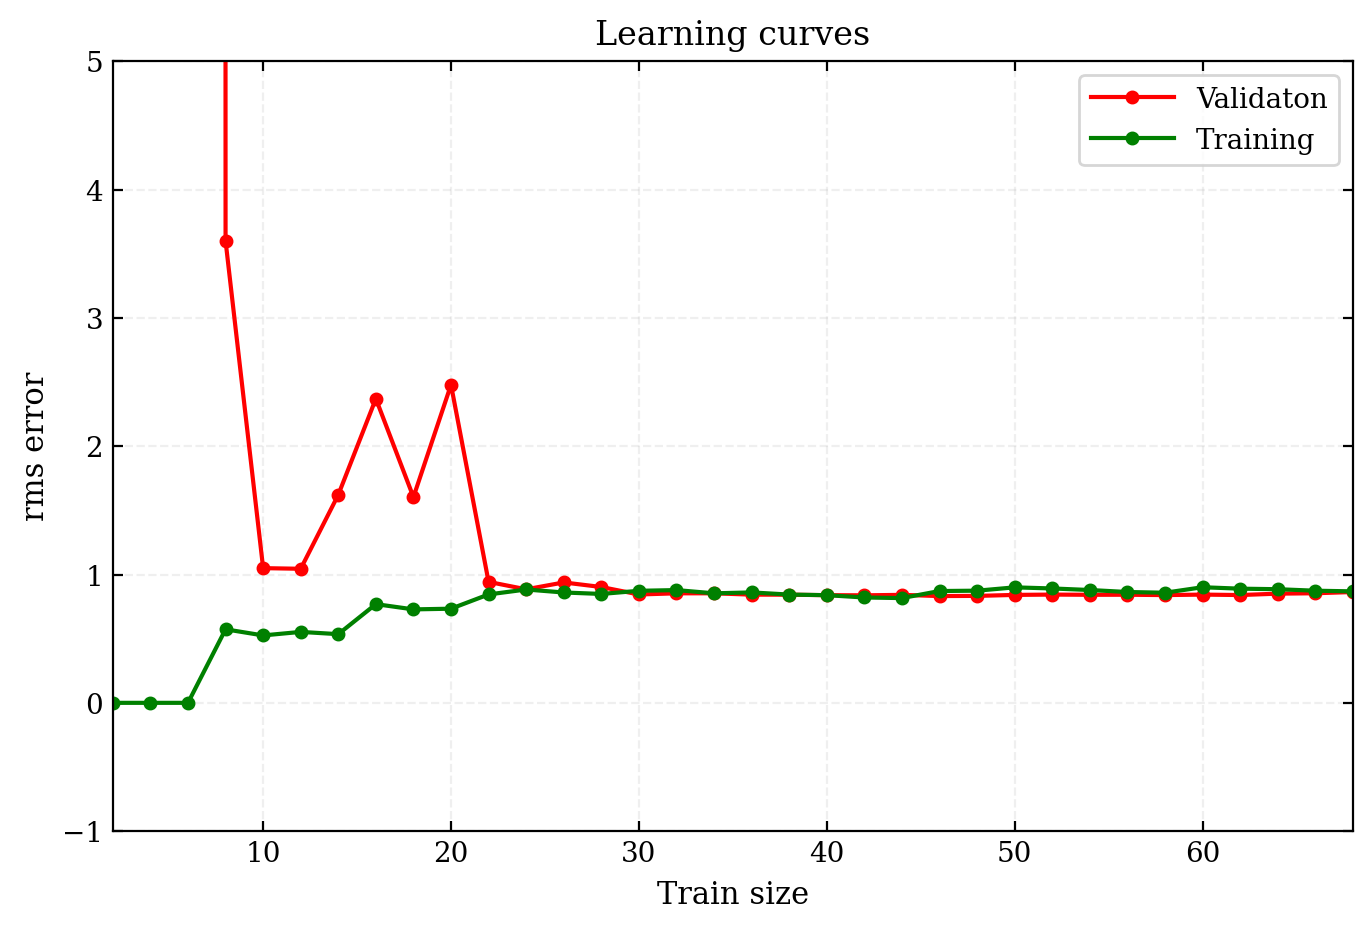

In [31]:
z_train, z_test, mu_train, mu_test, dmu_train, dmu_test = train_test_split(z_sample, mu_sample, dmu, test_size=ratio, 
                                                      random_state=3, shuffle=True)
Nrange = np.arange(2, len(z_train), 2) #This defines the increasing number of points in the training set

training_err = np.zeros(Nrange.shape)
val_err = np.zeros(Nrange.shape)

for j, N in enumerate(Nrange):
    p_coeff = np.polyfit(z_train[:N], mu_train[:N], best_n)
    training_err[j] = np.sqrt(np.sum((np.polyval(p_coeff, z_train[:N])
                                          - mu_train[:N]) ** 2) / len(mu_train[:N]))
    val_err[j] = np.sqrt(np.sum((np.polyval(p_coeff, z_test)
                                          - mu_test) ** 2) / len(mu_test))
#_________________________________________________________________________________________

fig = plt.figure(figsize=(8, 5))

plt.plot(Nrange, val_err, '-o', color="r", label="Validaton", markersize=4)
plt.plot(Nrange, training_err, '-o', color="g", label="Training", markersize=4)
                   
plt.xlabel("Train size",fontsize=11)
plt.ylabel("rms error",fontsize=11)
plt.title('Learning curves',fontsize=12)
plt.legend(loc="best")
plt.ylim(-1, 5)
plt.grid(True, ls='--', alpha=0.2)
plt.show()

As we can noticed from the **learning curve**, a training set with $\approx 30$ data points is enough to reach the convergence regime of the training error and the validation error. This regime is a sign of the fact that adding more training points will not result in a better fit. In this case, if you want to lower the overall error you need to pick a more sophisticated model.

This result also guarantees that the **10-Fold Cross Validation** implemented above was leaving the training set with enough data points. Indeed, in principle you could even decrease the number of data points in the training sets, for example choosing a "$<10$"-Fold Cross Validation, leaving more data points for validation.

---
### Basis Function Regression

Let's repeat the same procedures moving to a "**Basis Function Regression**" with a Gaussian basis, where we try to fit our dataset with a linear combination of five Gaussians, located at evenly spaced positions between 0 and 1. The fit is computing the value of the combination coefficients. 

We repeat this for 10 different gaussian widths and validate the model on the *test set* in order to find the optimal $\sigma$. This can also be done with respect to other hyperparameters such as the number of gaussian components.

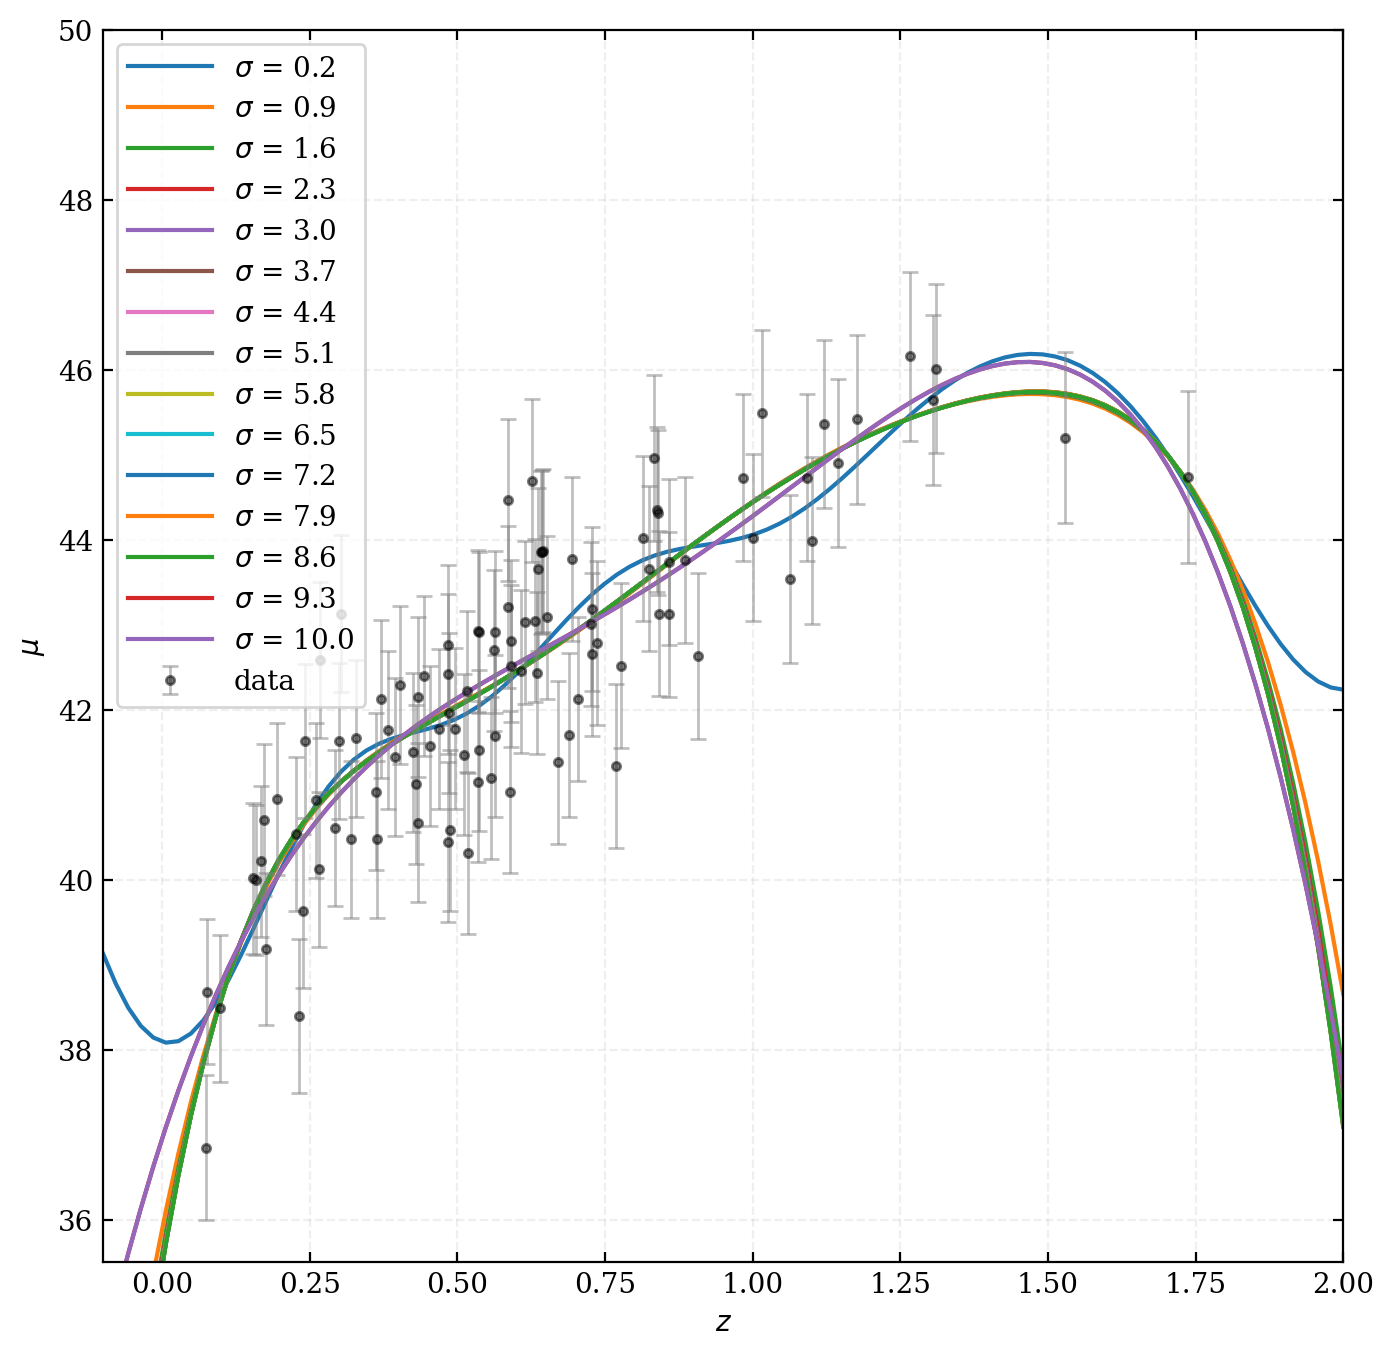

In [23]:
fig = plt.figure(figsize=(8, 8))
mu_gridtest = np.linspace(0,2,5)[:, None] # These are evenly spaced locations for the Gaussian basis
sigma_test = np.linspace(0.2, 10., 15) # 5 different sigma values

for sigma in sigma_test:
    model = BasisFunctionRegression('gaussian', mu=mu_gridtest, sigma=sigma)
    model.fit(z_sample[:, None], mu_sample, dmu)
    y_pred = model.predict(xgrid[:, None])
    plt.plot(xgrid, y_pred, label=f'$\sigma$ = {round(sigma, 1)}')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data', alpha=0.5)
plt.xlim(-0.1, 2)
plt.ylim(35.5, 50)
plt.xlabel(f'$z$')
plt.ylabel(f'$\mu$')
plt.legend(loc='upper left', frameon=True)
plt.grid(True, ls='--', alpha=0.2)

#### Validation:

Best Basis Function (Gaussian) Regression: sigma = 9.3


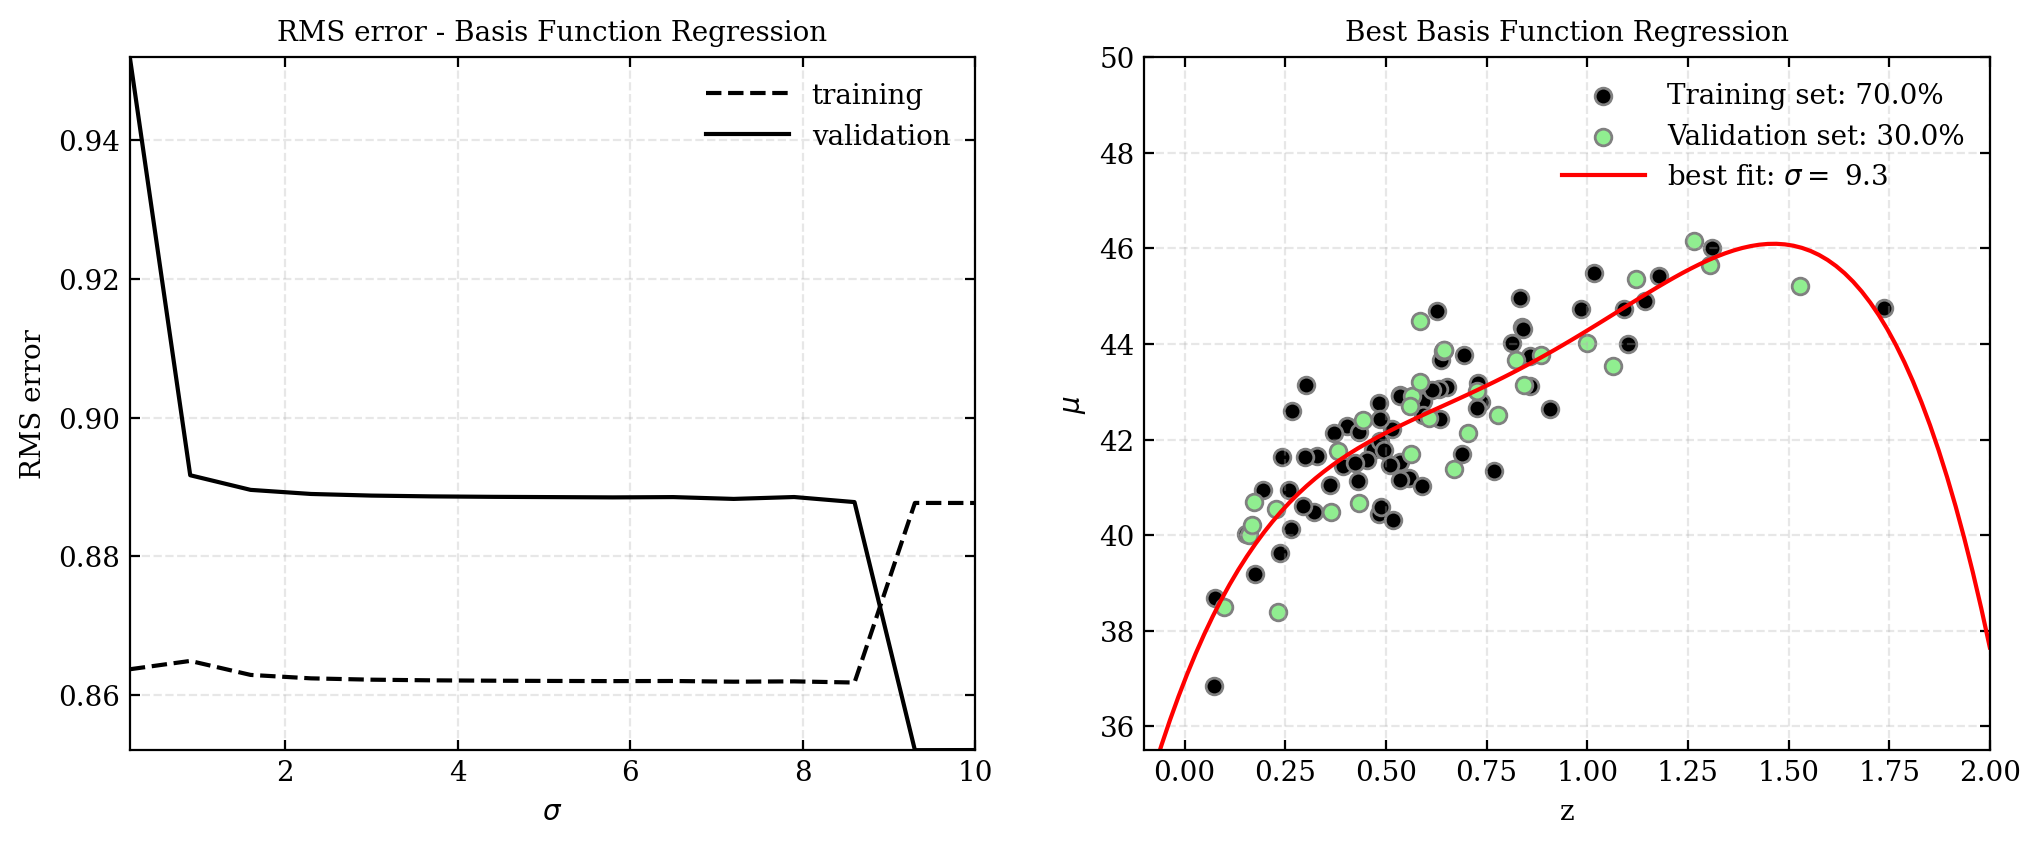

In [19]:
test_err = np.zeros(len(sigma_test))
train_err = np.zeros(len(sigma_test))

for i, sigma in enumerate(sigma_test):
    model = BasisFunctionRegression('gaussian', mu=mu_gridtest, sigma=sigma)
    model.fit(z_train[:,None], mu_train, dmu_train)
    
    test_err[i] = my_loss_func(mu_test, model.predict(z_test[:, None]))
    train_err[i] = my_loss_func(mu_train, model.predict(z_train[:, None]))
    
fig, ax = plt.subplots(1, 2, figsize=(12,4.5))

plt.subplot(121)

plt.plot(sigma_test, train_err, ls='--', c='k', label='training')
plt.xlabel(f'$\sigma$')
plt.ylabel('RMS error')

plt.plot(sigma_test, test_err, ls='-', c='k', label='validation')

plt.title('RMS error - Basis Function Regression')
plt.legend(loc='best', frameon=False);
# plt.ylim(0.85,0.9)

best_sigma = sigma_test[np.where(test_err == test_err.min())][0]
# Let's plot the best model according to the previous validation
print('Best Basis Function (Gaussian) Regression: sigma =', best_sigma)

model_ = BasisFunctionRegression('gaussian', mu=mu_gridtest, sigma=best_sigma)
model_.fit(z_sample[:, None], mu_sample, dmu)
xgrid = np.linspace(-0.1, 2, 100)
ypred = model_.predict(xgrid[:, None])

plt.subplot(122)
# plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data', alpha=0.8)
plt.scatter(z_train, mu_train, c='k', edgecolor='gray',label=f'Training set: {(1-ratio)*100}%')
plt.scatter(z_test, mu_test, c='lightgreen', edgecolor='gray', label=f'Validation set: {ratio*100}%')
plt.plot(xgrid, ypred, c='r', label=f'best fit: $\sigma = $ {best_sigma}')
plt.xlim(-0.1, 2)
plt.ylim(35.5, 50)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Best Basis Function Regression')
plt.legend(loc='best', frameon=False);

for _ in ax:
    _.grid(True, ls='--', alpha=0.3)

---
### Kernel Regression (Gaussian Kernel)

Let's repeat one last time using **Kernel Regression**, where the "Basis" functions are located at every data point.

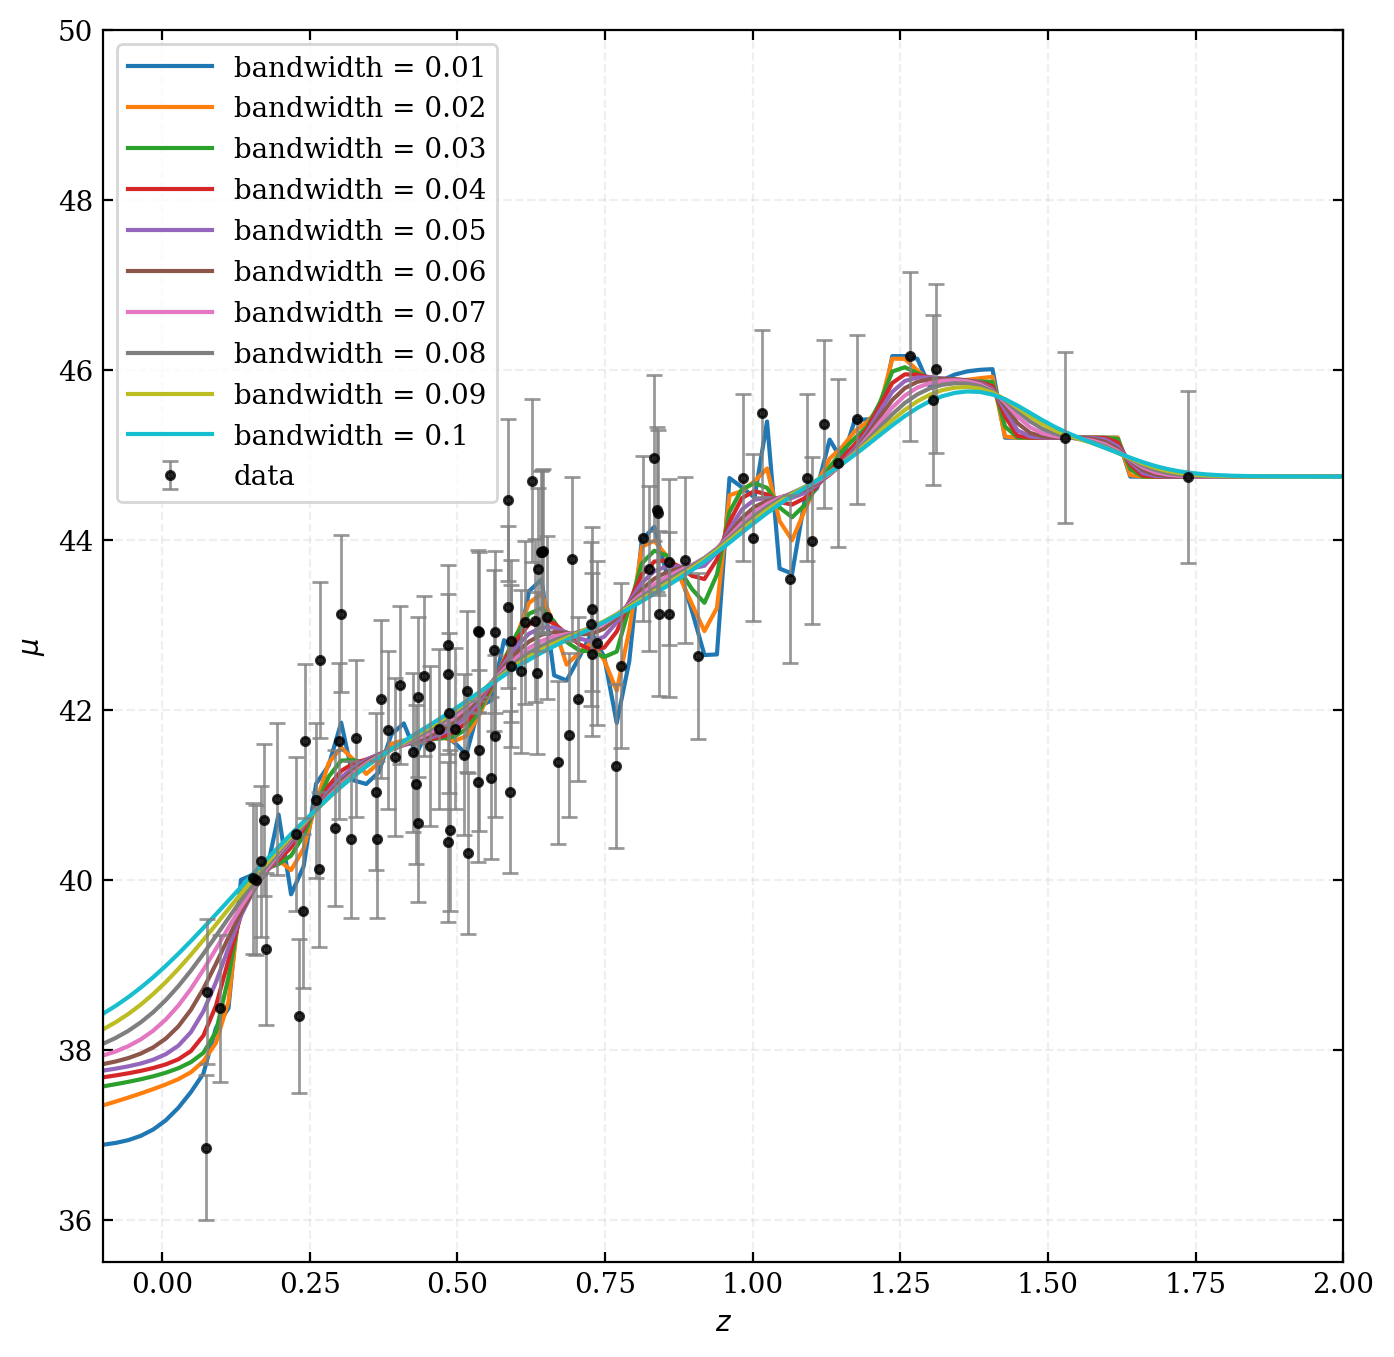

In [21]:
fig = plt.figure(figsize=(8, 8))
bandwidth = np.linspace(0.01, 0.1, 10) # 10 different sigma values

for bd in bandwidth:
    model = NadarayaWatson('gaussian', bd)
    model.fit(z_sample[:, None], mu_sample, dmu)
    y_pred = model.predict(xgrid[:, None])
    plt.plot(xgrid, y_pred, label=f'bandwidth = {round(bd, 2)}')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data', alpha=0.8)
plt.xlim(-0.1, 2)
plt.ylim(35.5, 50)
plt.xlabel(f'$z$')
plt.ylabel(f'$\mu$')
plt.legend(loc='upper left', frameon=True)
plt.grid(True, ls='--', alpha=0.2)

#### Validation:

Best Kernel Regression: bandwidth = 0.07


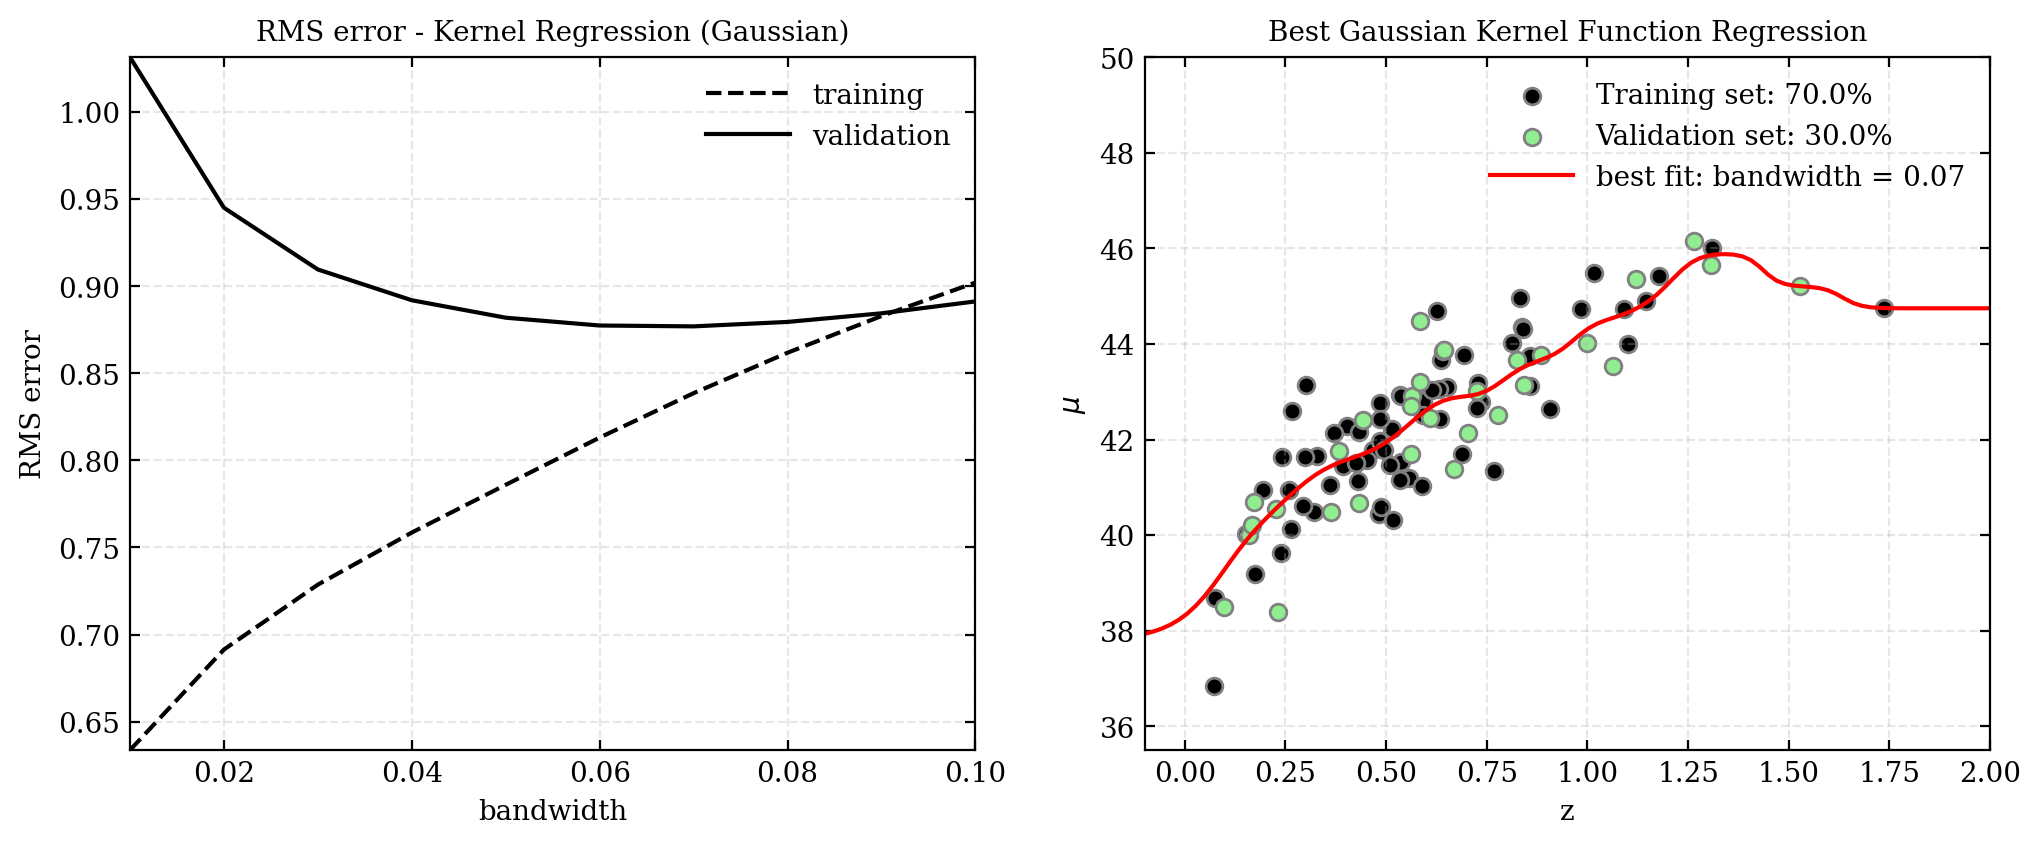

In [20]:
test_err = np.zeros(len(bandwidth))
train_err = np.zeros(len(bandwidth))

for i, bd in enumerate(bandwidth):
    model = NadarayaWatson('gaussian', bd)
    model.fit(z_train[:,None], mu_train, dmu_train)
    
    test_err[i] = my_loss_func(mu_test, model.predict(z_test[:, None]))
    train_err[i] = my_loss_func(mu_train, model.predict(z_train[:, None]))
    
fig, ax = plt.subplots(1, 2, figsize=(12,4.5))

plt.subplot(121)

plt.plot(bandwidth, train_err, ls='--', c='k', label='training')
plt.xlabel(f'bandwidth')
plt.ylabel('RMS error')

plt.plot(bandwidth, test_err, ls='-', c='k', label='validation')

plt.title('RMS error - Kernel Regression (Gaussian)')
plt.legend(loc='best', frameon=False);
# plt.ylim(0.85,0.9)

best_band = bandwidth[np.where(test_err == test_err.min())][0]
# Let's plot the best model according to the previous validation
print('Best Kernel Regression: bandwidth =', best_band)

model_ = NadarayaWatson('gaussian', best_band)
model_.fit(z_sample[:, None], mu_sample, dmu)
xgrid = np.linspace(-0.1, 2, 100)
ypred = model_.predict(xgrid[:, None])

plt.subplot(122)
plt.scatter(z_train, mu_train, c='k', edgecolor='gray',label=f'Training set: {(1-ratio)*100}%')
plt.scatter(z_test, mu_test, c='lightgreen', edgecolor='gray', label=f'Validation set: {ratio*100}%')
plt.plot(xgrid, ypred, c='r', label=f'best fit: bandwidth = {round(best_band, 2)}')
plt.xlim(-0.1, 2)
plt.ylim(35.5, 50)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Best Gaussian Kernel Function Regression')
plt.legend(loc='best', frameon=False);

for _ in ax:
    _.grid(True, ls='--', alpha=0.3)